In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [15]:
results = search_images_ddg('diffenbachia')
ims = results
len(ims)

200

In [6]:
dest = 'images/diffenbachia.jpg'

In [20]:
download_url(ims[2], dest)

Path('images/diffenbachia.jpg')

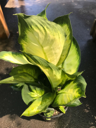

In [61]:
im = Image.open(dest)
im.to_thumb(128,128)

In [21]:
plant_types = 'diffenbachia', 'monstera', 'spider'
path = Path('plants')

In [31]:
if not path.exists():
    path.mkdir()
    for o in plant_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} plant')
        download_images(dest, urls=results)

In [32]:
fns = get_image_files(path)
fns

(#504) [Path('plants/diffenbachia/dd4744cb-3fc1-4902-9167-e6fdf06ea418.jpg'),Path('plants/diffenbachia/beabed01-669e-4cc4-bfab-8f2f10b18628.jpg'),Path('plants/diffenbachia/3132c9e2-a7e3-499f-8678-5926d57fa906.jpg'),Path('plants/diffenbachia/e0cbce26-d2da-4e24-b189-ebd0ca180040.jpg'),Path('plants/diffenbachia/1b10ace0-0b07-4c4e-bfd0-fff39b7427e2.jpg'),Path('plants/diffenbachia/1e0f45d8-e38d-40b3-adac-c838f1f196d5.jpg'),Path('plants/diffenbachia/1ced2213-169b-4694-84ef-5ffd5d0b00b3.jpg'),Path('plants/diffenbachia/afa38733-e3f8-434b-974b-e544a3d90b36.jpg'),Path('plants/diffenbachia/1c8d1cdb-ce24-44f2-bcdb-a67eff056211.jpeg'),Path('plants/diffenbachia/a8fbd4b5-c2d0-4038-ba9c-b3ade916359b.jpg')...]

In [33]:
failed = verify_images(fns)
failed

(#13) [Path('plants/diffenbachia/ee0e5b92-df67-438f-b1b4-5d0e3c5af307.png'),Path('plants/diffenbachia/2d9d9f0a-72cd-40f5-8f85-6a04945a1bb4.jpg'),Path('plants/diffenbachia/31c46f84-ca05-43f3-9e71-cf3ee66f4529.jpg'),Path('plants/diffenbachia/1392143d-b431-464e-8043-ce88e731b0ff.jpg'),Path('plants/diffenbachia/c566ea4f-f5c3-4e8a-ba16-3e07f0fdf2e4.jpg'),Path('plants/spider/f9347570-6ff0-4c27-be2a-857b5552fff1.jpg'),Path('plants/spider/5399f8ee-1eb5-43c7-a0cb-df8ebda0dfc2.jpg'),Path('plants/spider/e29d8dfe-5066-4c9a-98ac-f9553b51148d.jpg'),Path('plants/monstera/cfbc00ad-06b7-4514-b808-33913645c062.jpg'),Path('plants/monstera/0b76a818-4e4e-4d23-94ac-7db3a41405f9.jpg')...]

In [34]:
failed.map(Path.unlink);

In [35]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128, ResizeMethod.Squish),
    batch_tfms=aug_transforms(mult=2))

In [36]:
dls = plants.dataloaders(path)

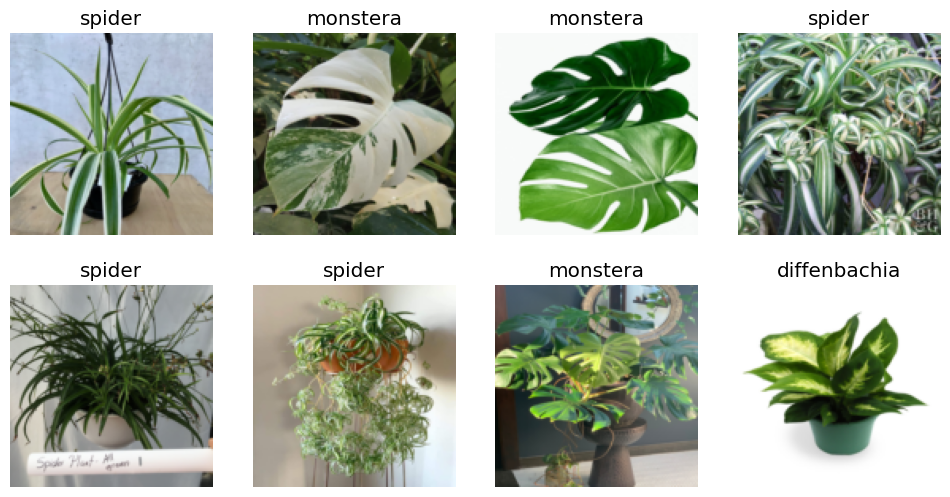

In [37]:
dls.valid.show_batch(max_n=8, nrows=2)

In [38]:
plants = plants.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                    batch_tfms=aug_transforms())

dls = plants.dataloaders(path)

In [39]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.547568,0.467359,0.193878,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.415101,0.134900,0.040816,00:24
1,0.316255,0.064724,0.010204,00:25
2,0.223698,0.067713,0.010204,00:24
3,0.183815,0.058602,0.010204,00:23


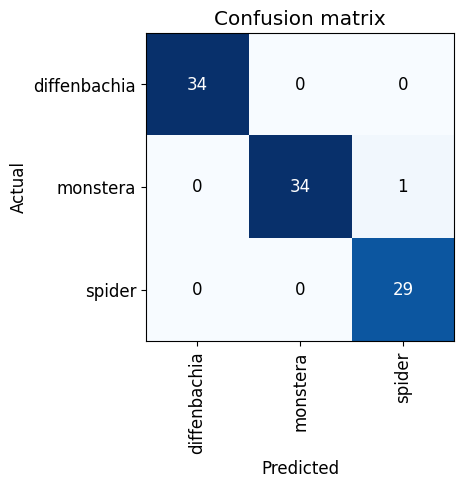

In [40]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

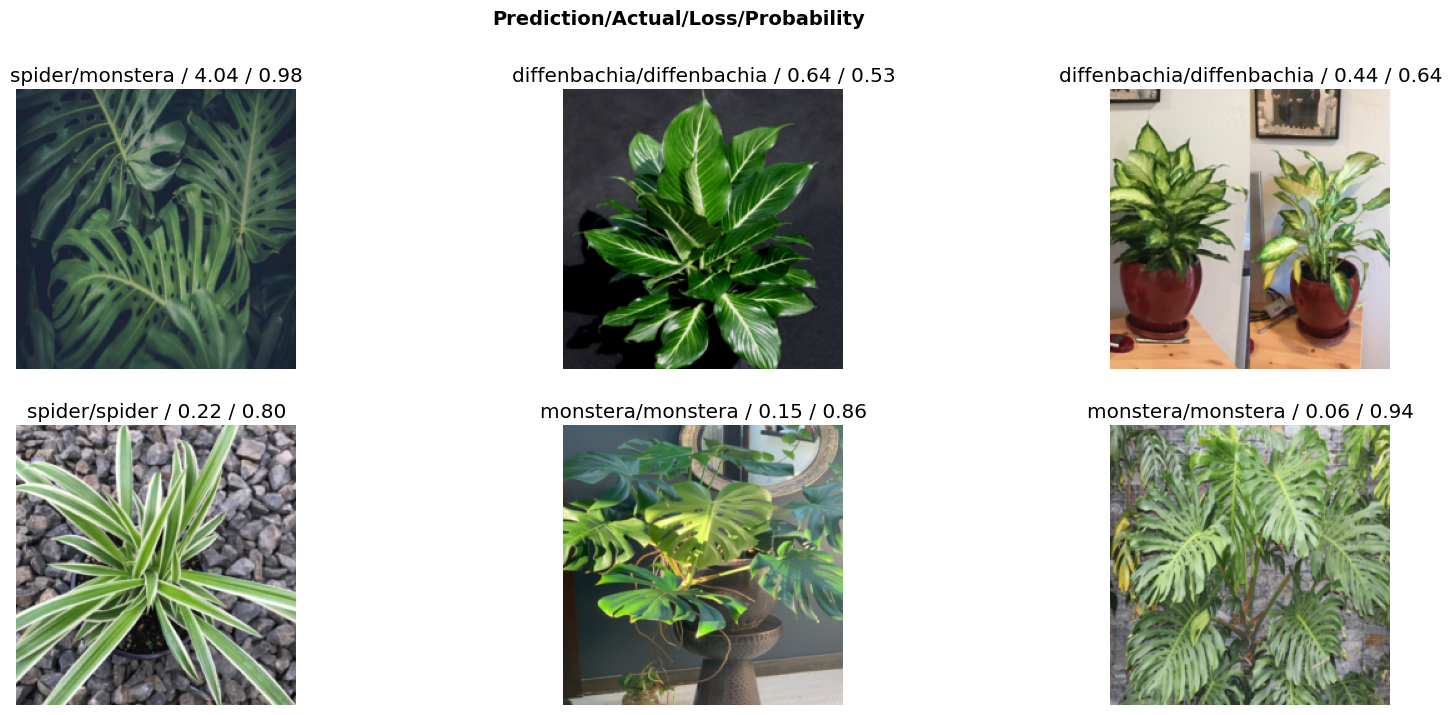

In [41]:
interp.plot_top_losses(6, nrows=2, figsize=(20,8))


In [42]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [43]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [44]:
learn.export()


In [45]:

path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [46]:
learn_inf = load_learner(path/'export.pkl')


In [47]:
learn_inf.predict('images/diffenbachia.jpg')


('diffenbachia', tensor(0), tensor([9.9983e-01, 4.3008e-07, 1.7393e-04]))

In [48]:
learn_inf.dls.vocab

['diffenbachia', 'monstera', 'spider']

In [49]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [50]:
btn_upload = SimpleNamespace(data = ['images/diffenbachia.jpg'])


In [51]:
img = PILImage.create(btn_upload.data[-1])


In [52]:

#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [53]:
pred,pred_idx,probs = learn_inf.predict(img)


In [54]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: diffenbachia; Probability: 0.9998')

In [55]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [56]:

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [57]:
btn_upload = widgets.FileUpload()


In [58]:
VBox([widgets.Label('Select your plant!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [59]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.3/380.3 kB 688.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 23.2.1
    Uninstalling pyzmq-23.2.1:
      Successfully uninstalled pyzmq-23.2.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting u

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.5.5 OK
